# Examples of using the various functions in `Utils`

In [1]:
%%capture
%load_ext autoreload
%autoreload 2
from antarctic_plots import fetch, regions, maps, utils

## Coordinate conversions and formats

Converting GMT region strings between meters in EPSG:3031 and lat long 

In [2]:
pig = regions.pine_island_glacier

pig_latlon = utils.GMT_reg_xy_to_ll(pig, decimal_degree=True)

print(pig)
print(pig_latlon)

[-1720000.0, -1480000.0, -380000.0, -70000.0]
[-104.40002130679105, -92.33051886797894, -76.42465660818513, -73.8906485263336]


plot [WARNING]: For a UTM or TM projection, your region -2140000.0/-30000.0/-1550000.0/1070000.0 is too large to be in degrees and thus assumed to be in meters


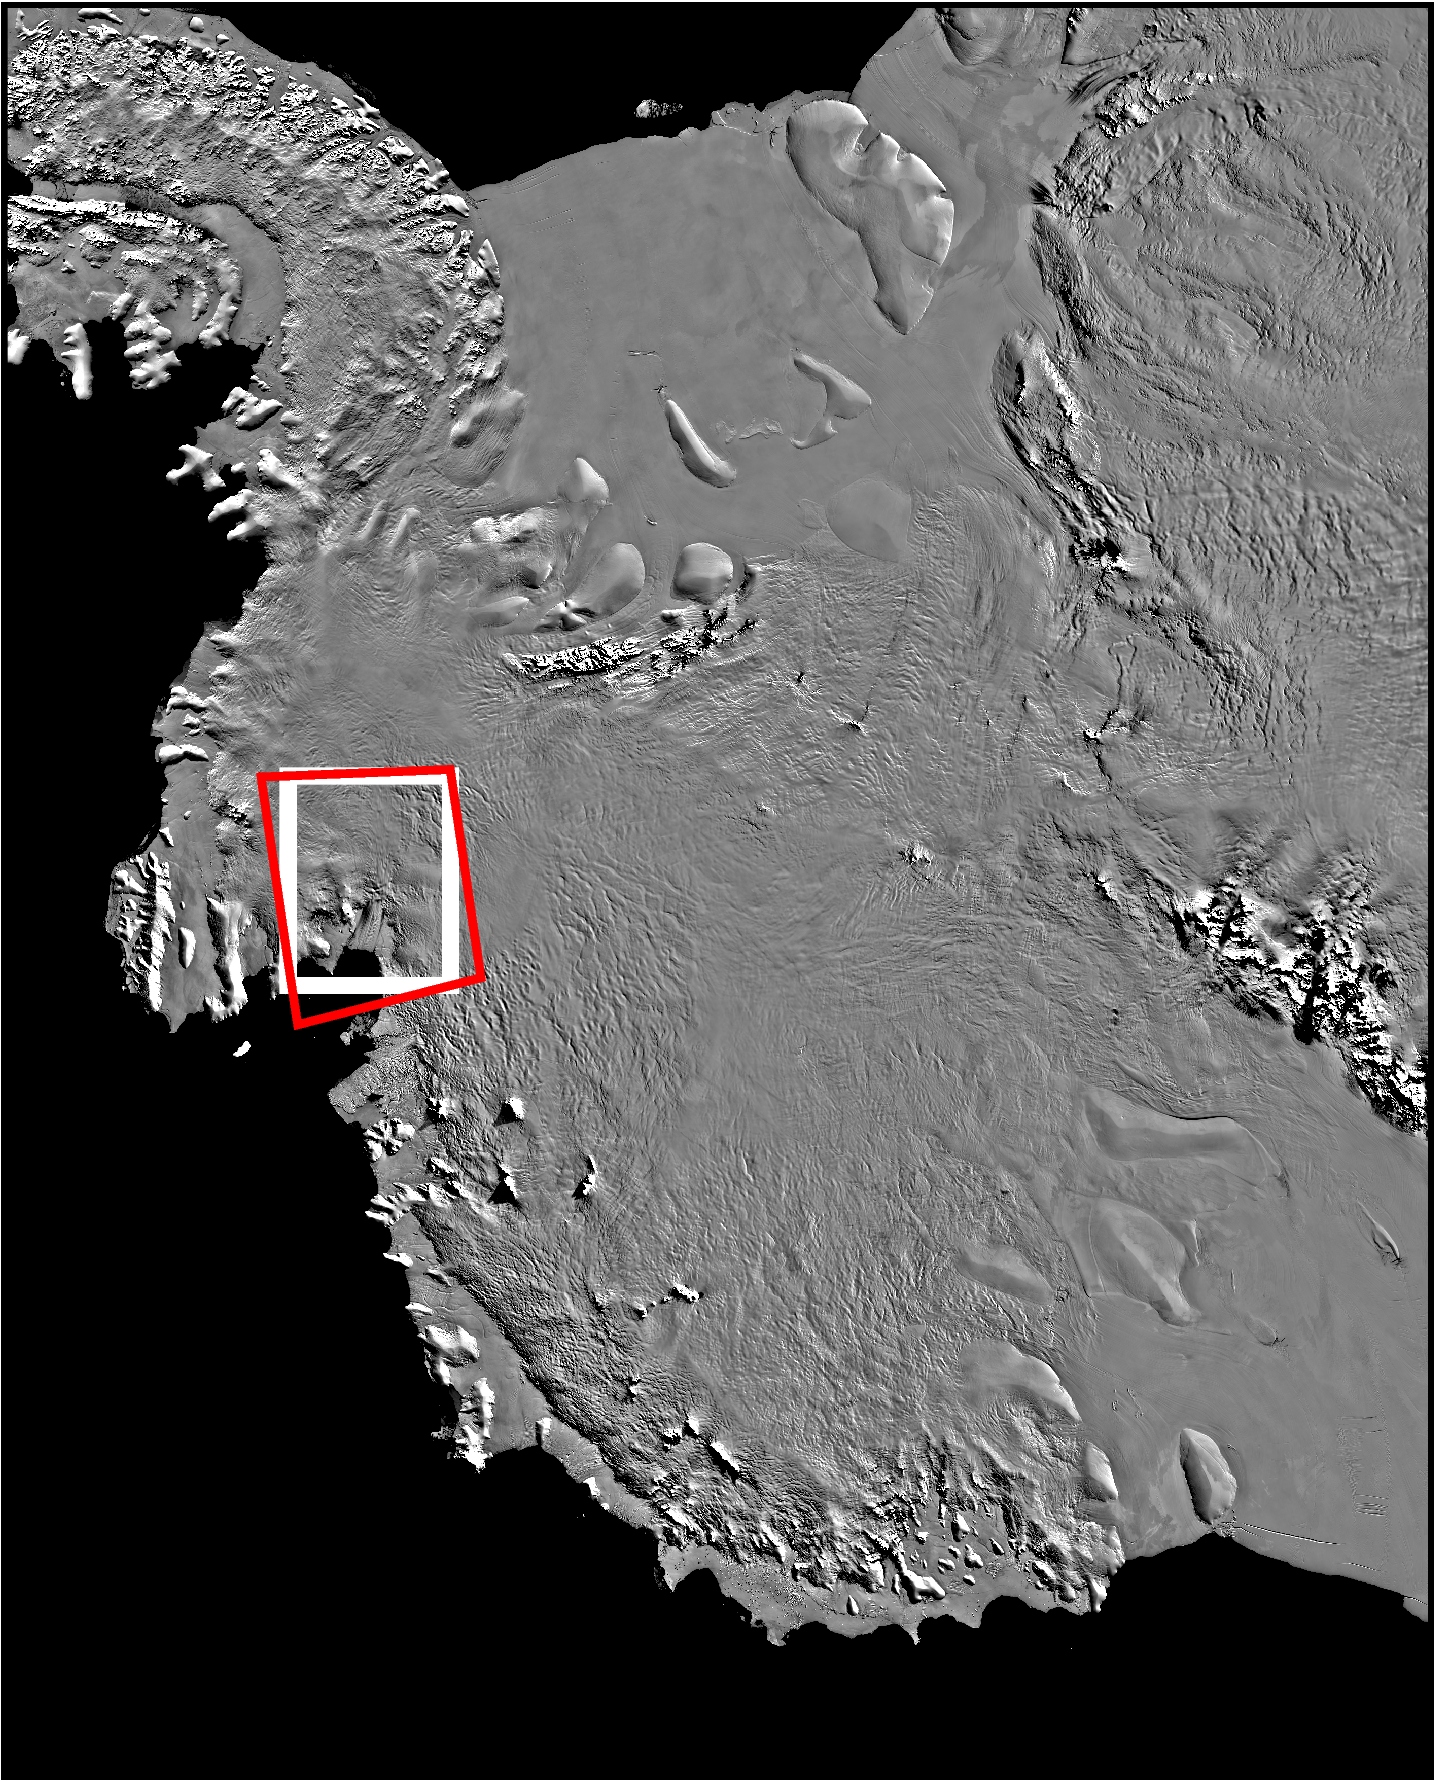

In [3]:
figure_region = utils.alter_region(regions.west_antarctica, zoom=600e3)[0]

fig = maps.plot_grd(
    fetch.modis_moa(),
    image=True,
    cmap="gray",
    plot_region=figure_region,
)

fig.plot(
    x=[pig[0], pig[0], pig[1], pig[1], pig[0]],
    y=[pig[2], pig[3], pig[3], pig[2], pig[2]],
    pen="4p,white",
)


fig.plot(
    projection=utils.set_proj(figure_region)[1],
    region=figure_region,
    x=[pig_latlon[0], pig_latlon[0], pig_latlon[1], pig_latlon[1], pig_latlon[0]],
    y=[pig_latlon[2], pig_latlon[3], pig_latlon[3], pig_latlon[2], pig_latlon[2]],
    pen="2p,red",
)

fig.show()

fig.savefig(
    "outputs/crs_plot.png",
)

### Converting from GMT region strings to other formats

In [4]:
# To use the boundingbox format used in IcePyx:

# region in meters in format [e, w, n, s]
lis = regions.larsen_ice_shelf
print(lis)

# convert to decimal degress
lis_latlon = utils.GMT_reg_xy_to_ll(lis, decimal_degree=True)
print(lis_latlon)

# switch order to [lower left lat, upper right long, uper right lat]
lis_bb = utils.GMT_reg_to_bounding_box(lis_latlon)
print(lis_bb)

[-2430000.0, -1920000.0, 900000.0, 1400000.0]
[-69.67686317033707, -53.901716032892004, -70.66216685997603, -64.59654842562178]
[-69.67686317033707, -70.66216685997603, -53.901716032892004, -64.59654842562178]


### Convert between EPSG:3031 and WGS84 lat/lon

In [5]:
# get coordinates for center of Roosevelt Island
RI = regions.roosevelt_island
RI_center = [((RI[0] + RI[1]) / 2), ((RI[2] + RI[3]) / 2)]
RI_center

[-360000.0, -1100000.0]

In [6]:
# convert to lat lon
RI_center_latlon = utils.epsg3031_to_latlon(RI_center)
print(RI_center_latlon)

# convert back to epsg 3031
epsg = utils.latlon_to_epsg3031(RI_center_latlon)
epsg

[-79.37689147851952, -161.87813975209863]


[-360000.0000000289, -1100000.0000000878]

plot [WARNING]: For a UTM or TM projection, your region -480000.0/-240000.0/-1220000.0/-980000.0 is too large to be in degrees and thus assumed to be in meters


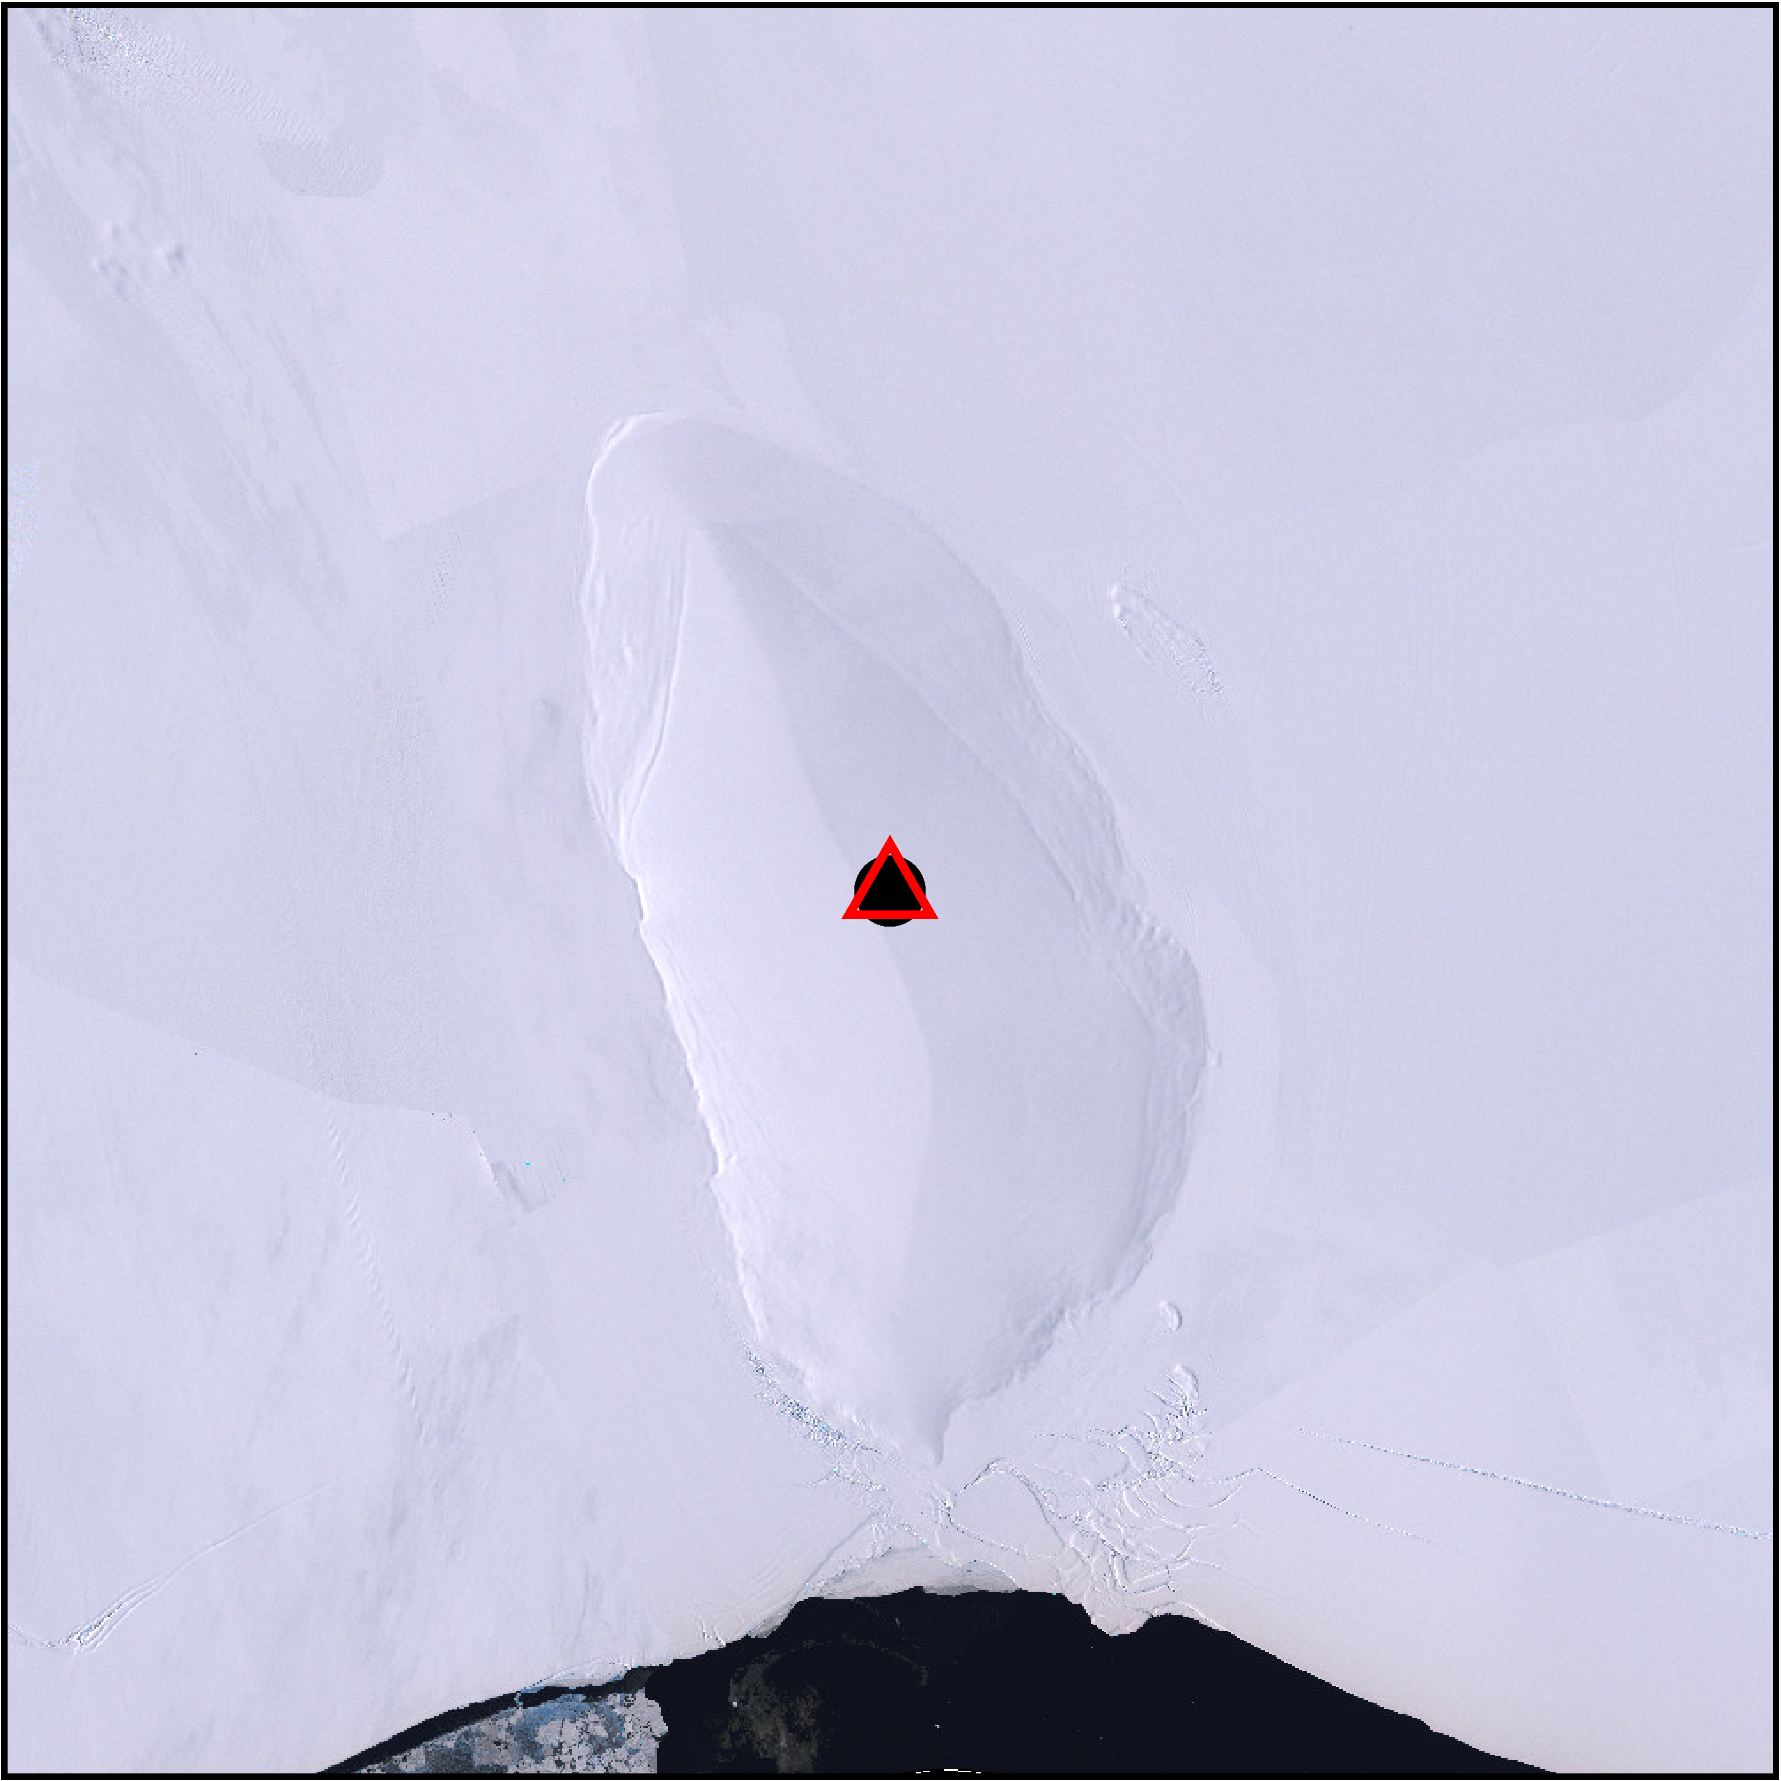

In [7]:
# plot on map
fig = maps.plot_grd(
    fetch.imagery(),
    plot_region=regions.roosevelt_island,
    image=True,
)

fig.plot(
    x=RI_center[0],
    y=RI_center[1],
    style="c.6c",
    color="black",
)
fig.plot(
    x=RI_center_latlon[1],
    y=RI_center_latlon[0],
    projection=utils.set_proj(regions.roosevelt_island)[1],
    style="t.8c",
    pen="2p,red",
)
fig.show()

## Grid processes

### Fit a trend to a grid and optionally remove it

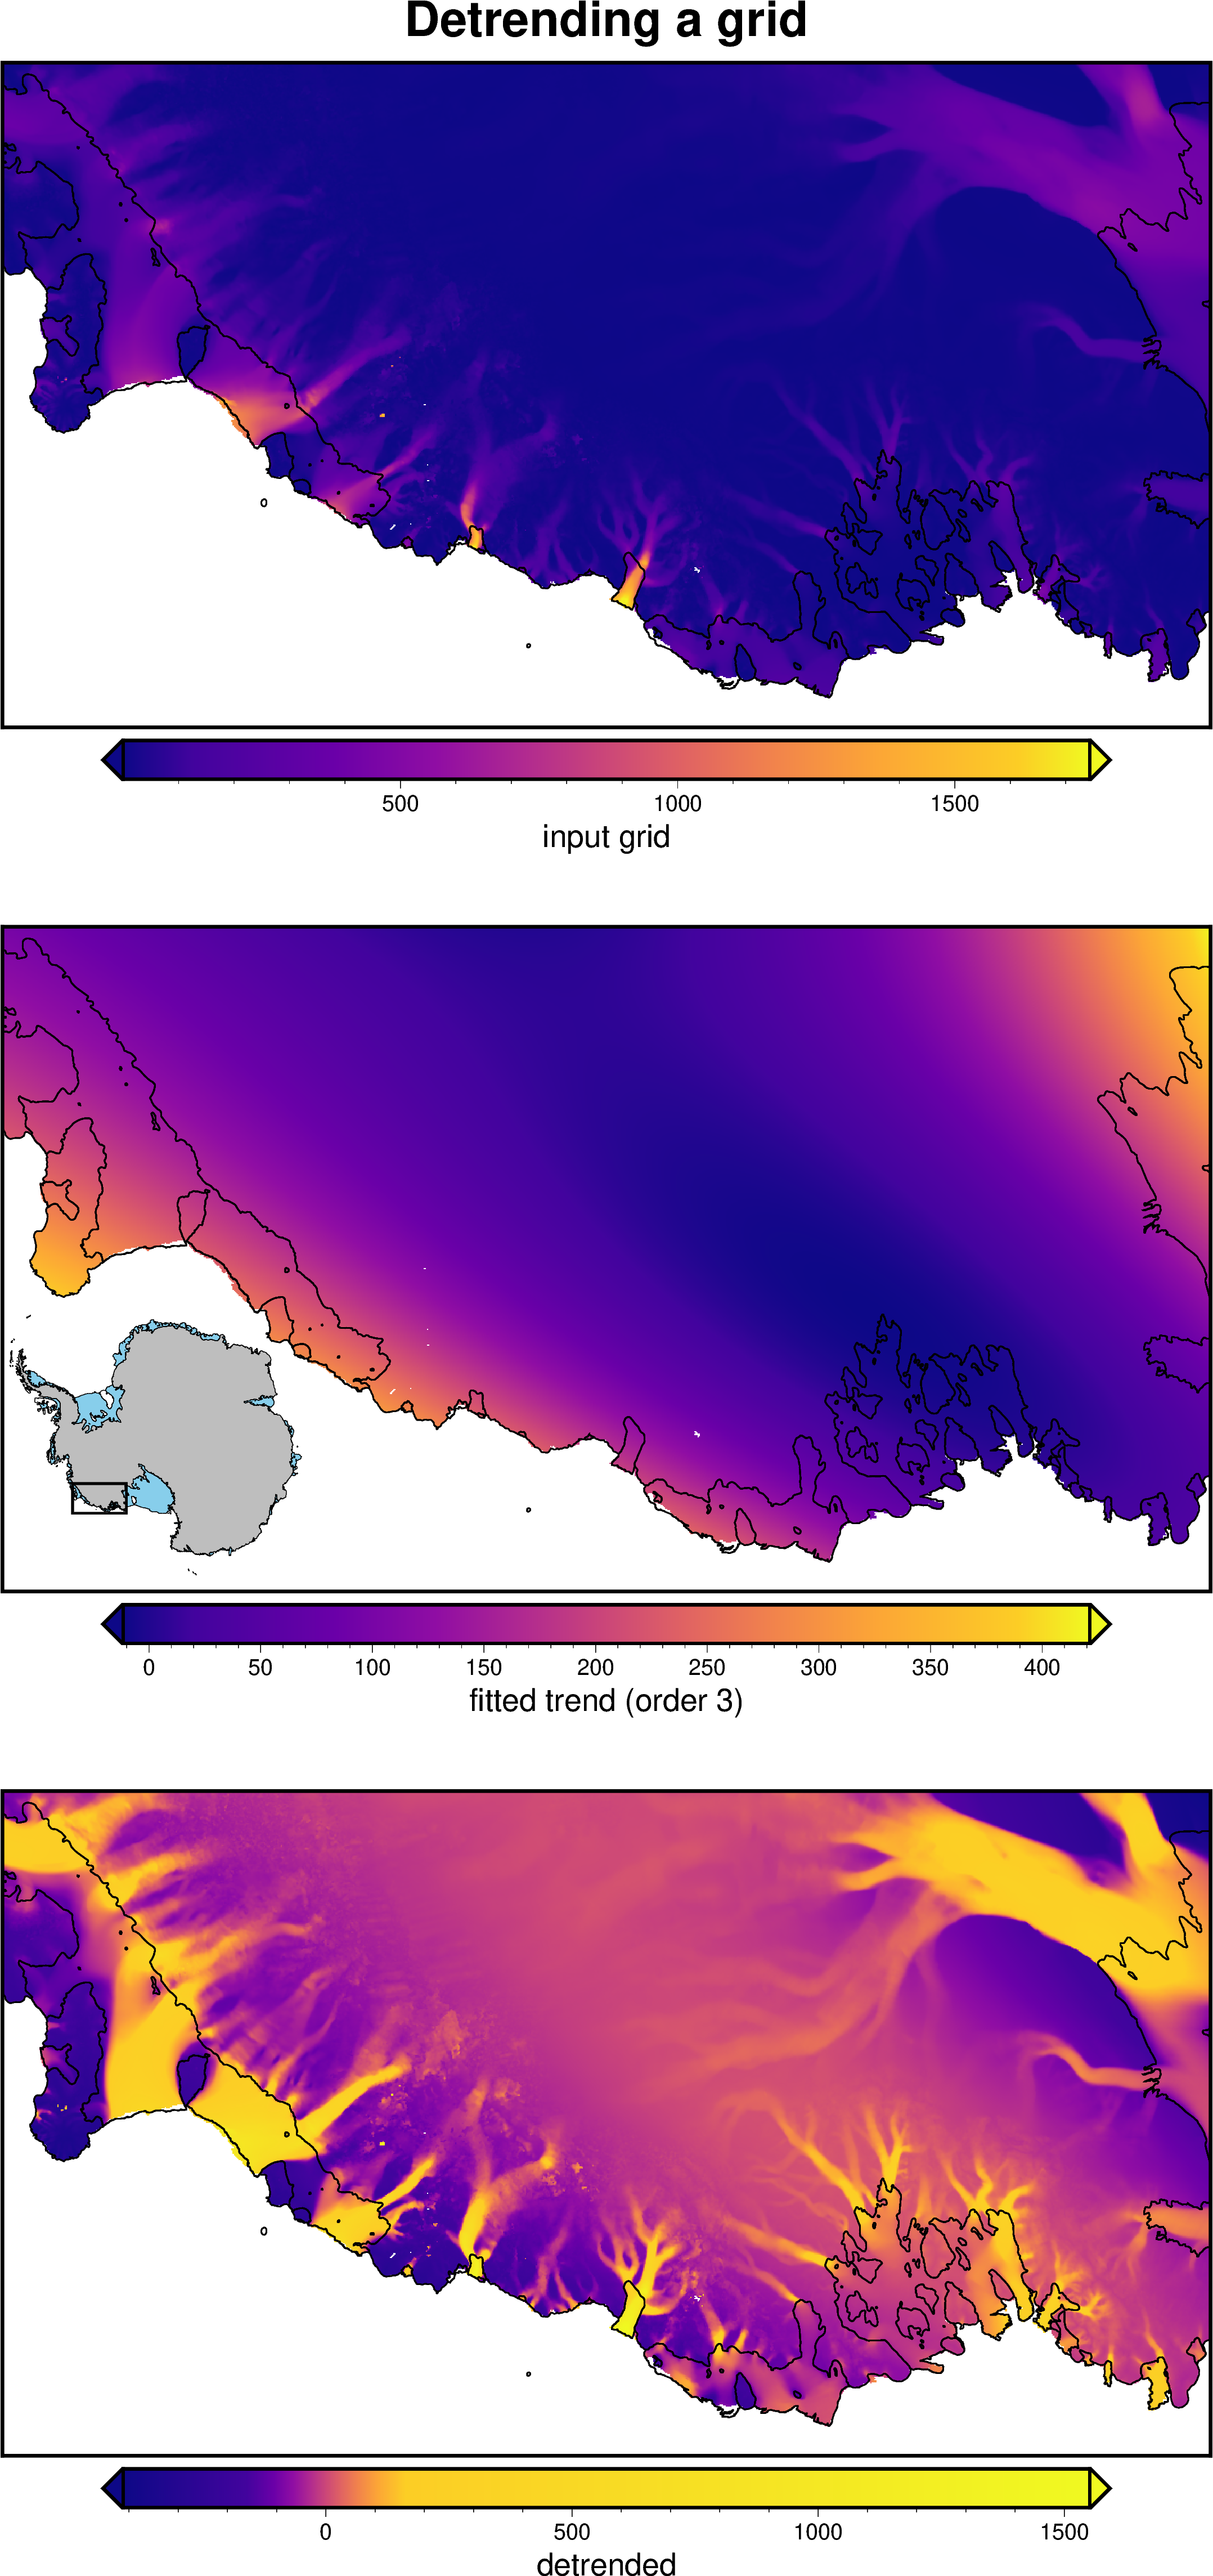

In [11]:
# download
ice_velocity = fetch.ice_vel(
    region=regions.marie_byrd_land,
    spacing=1e3)

# extract and detrend
fit, detrend = utils.grd_trend(
    ice_velocity, 
    deg=3,
    plot=True
    )

### compare two different grids

grid regions dont match, using inner region of supplied grids


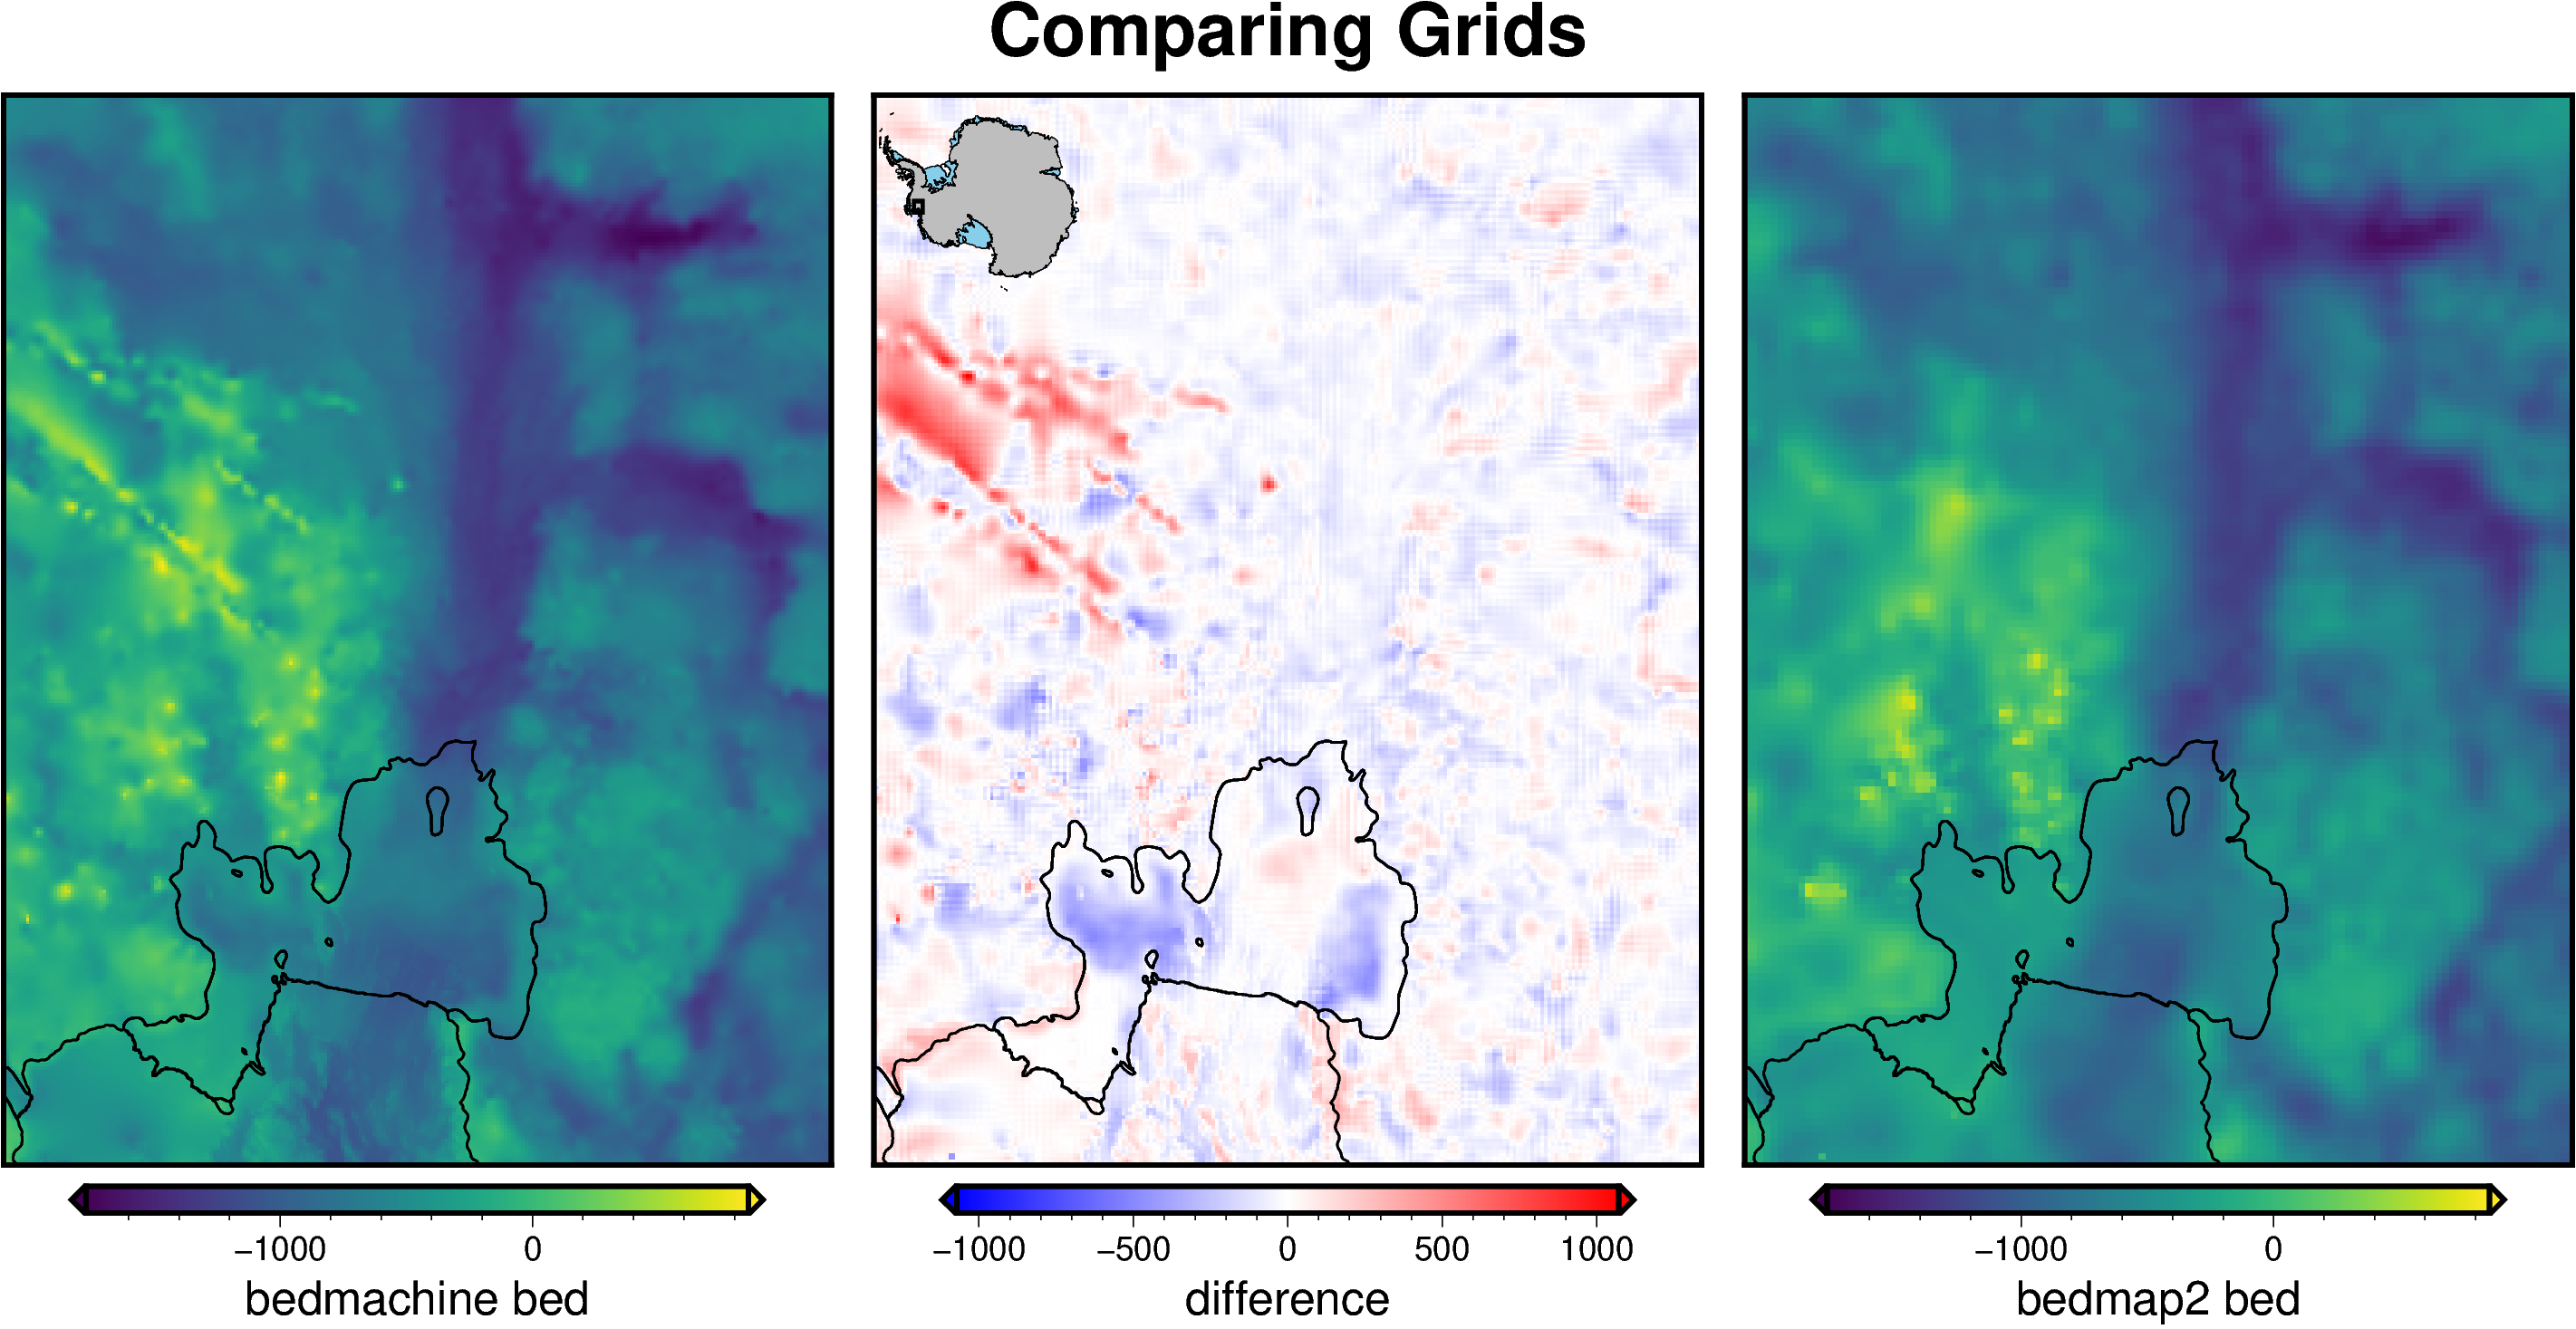

In [30]:
# define a region of interest
region = regions.pine_island_glacier

# load the 2 grids to compare, at 1km resolution
bedmachine = fetch.bedmachine(layer="bed", spacing=1e3, region=region)
bedmap = fetch.bedmap2(layer="bed", spacing=1e3, region=region)

# run the difference function and plot the results
dif, grid1, grid2 = utils.grd_compare(
    bedmachine,
    bedmap,
    plot=True,
    grid1_name="bedmachine bed",
    grid2_name="bedmap2 bed",
)

Lets say we're only interested in the region under the ice shelf (the closed black polygon). Higher or lower values outside of the ice shelf are skewing the color ramp. We can use a regional mask to set the colorscale's max and min values based on a shapefile. We'll define a shapefile for the island, and re-run the above code with the kwarg `shp_mask`.

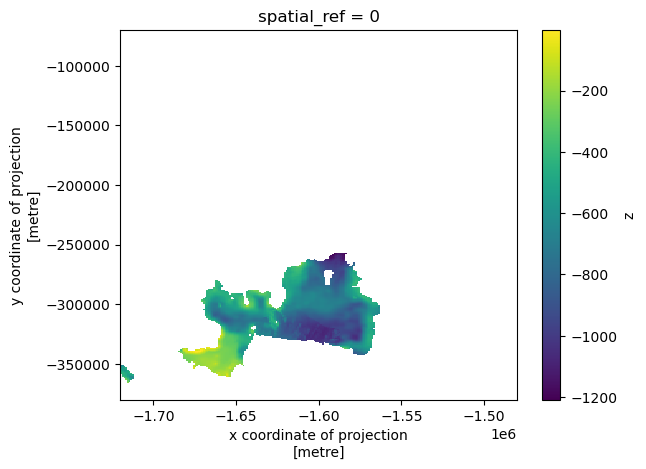

In [24]:
# load the grounding and coast line database
import pyogrio

shp = pyogrio.read_dataframe(fetch.groundingline())

# subset only the ice shelf region for the mask. See the Fetch Walkthrough for the groundingline ID classifications
shp_mask = shp[shp.Id_text == "Ice shelf"]

# view the mask area:
utils.mask_from_shp(shp_mask, xr_grid=grid1, masked=True, invert=False).plot()

grid regions dont match, using inner region of supplied grids


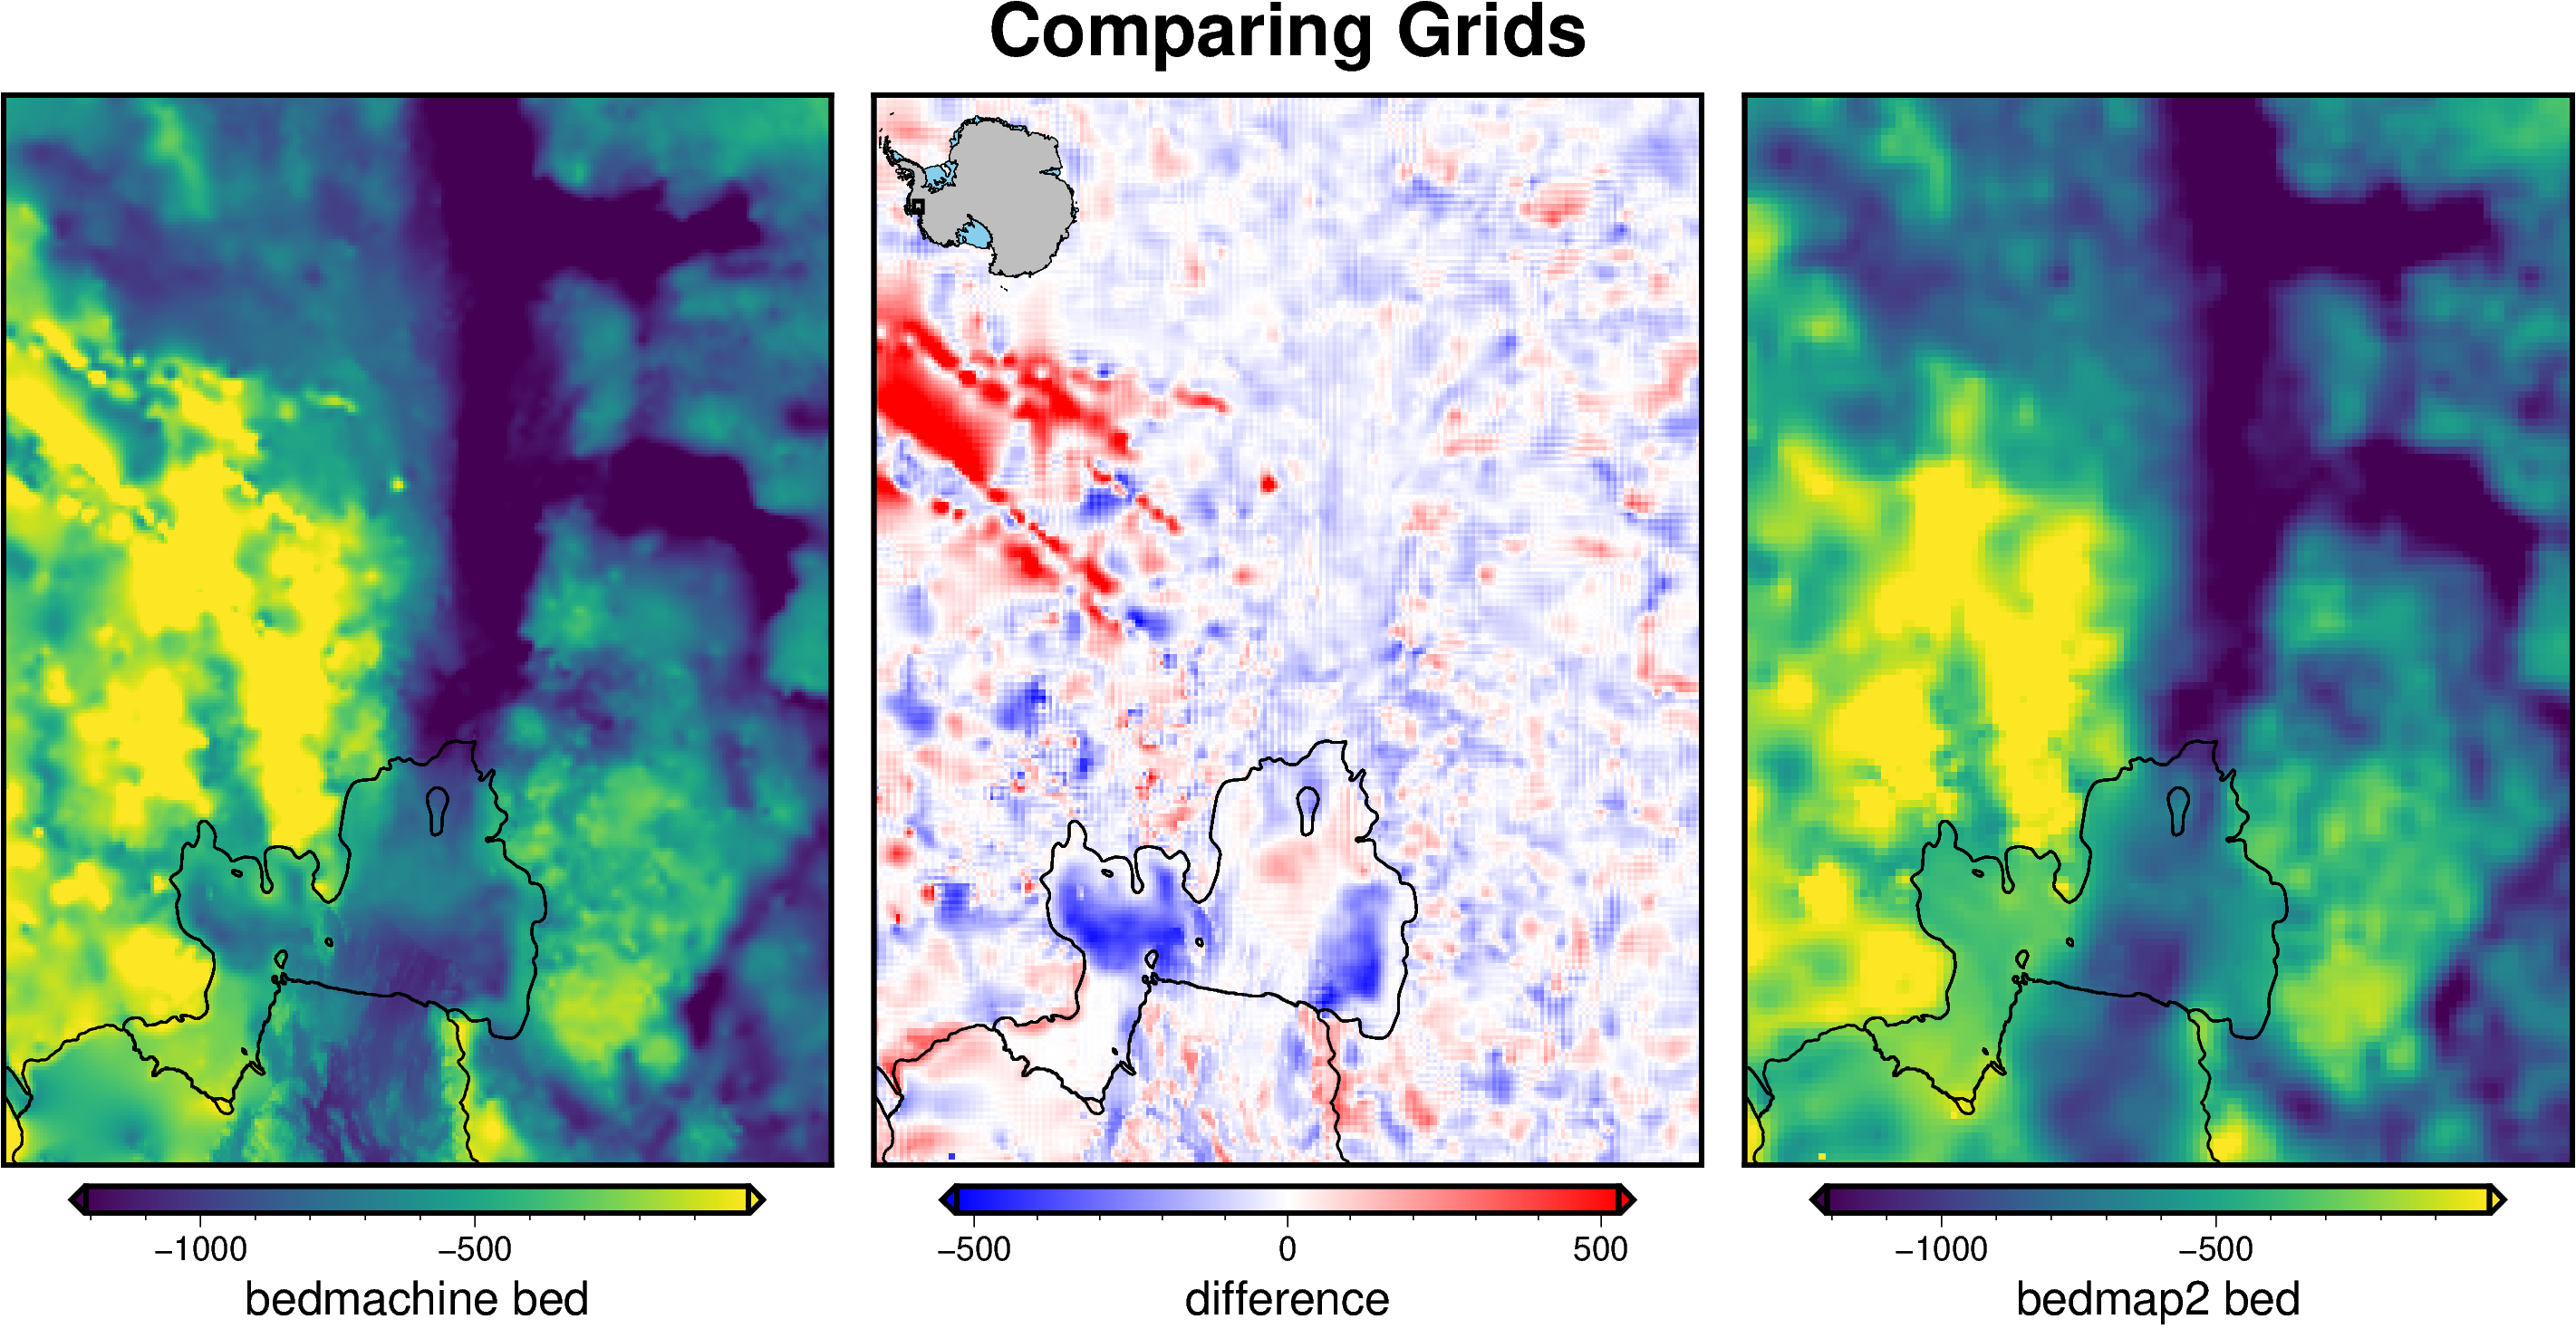

In [29]:
# re-run the difference function.
# note how the color scale are now set to just the sub-ice-shelf regions.
dif, grid1, grid2 = utils.grd_compare(
    bedmachine,
    bedmap,
    plot=True,
    grid1_name="bedmachine bed",
    grid2_name="bedmap2 bed",
    shp_mask=shp_mask,
)

In [28]:
import verde as vd
vd.maxabs(utils.get_min_max(dif, shp_mask))

528.266

### radially averaged power spectrum

In [32]:
# coming soon

### coherency between 2 grids

In [ ]:
# coming soon